## An Exploration of Bulletproofs [INCOMPLETE]
> short like a bullet, and with bulletproof security assumptions
### Sean Flannery
### sflanner@purdue.edu
#### CS 590 - Practical & Applied Cryptography Project

NOTE: If you're running this, be sure to hop to the bottom of this notebook and run the cells labelled "RUN ME" before progressing with execution.

Sources:
- [Rust Library Documentation](https://doc-internal.dalek.rs/bulletproofs/index.html)
- [The Bulletproof Protocols - Tari Labs University](https://tlu.tarilabs.com/cryptography/bulletproofs-protocols/MainReport.html)
- [Stanford Applied Crypto - Bulletproofs](https://crypto.stanford.edu/bulletproofs/)
- [Haskell Pedersen Commitments](https://hackage.haskell.org/package/pedersen-commitment)
- [Useful Figures](https://cathieyun.medium.com/building-on-bulletproofs-2faa58af0ba8)

### Introduction

#### Motivation
My motivation with this project was to both 
1. understand what the heck a bulletproof is (it's not just butter in coffee) and 
2. dive into the true, underlying implementations within a bulletproof rather than use the nice APIs provided from libraries like the wonderful `dalek-cryptography` library! 

I wanted to get a better understanding of what goes into these wrappers that are largely provided for me (like Pedersen commitments, generators etc).

#### Importance
Bulletproofs (and zero-knowledge proofs more broadly) make up a central component of systems that we rely upon to support growing industries/infrastructures. 

Bulletproofs were designed in part to enable fast, confidential smart contract transactions to occur between cryptocurrencies. A fun statistic out there is that (due to some really wild proof aggregation techniques) 
>"If all Bitcoin transactions were confidential and used Bulletproofs, then the total size of the **UTXO set** would be only 17 GB, compared to 160 GB with the currently used proofs."

DEFINITION: **"UTXO set"**: Thus, the set represents all of the coins in a particular cryptocurrency system. The complete UTXO set can be summed to calculate the **total supply of a cryptocurrency** at a given point in time.

### Goals 
1. Read through some of the existing [Rust library documentation]( https://doc-internal.dalek.rs/bulletproofs/index.html ) on bulletproofs and their purpose
    - I now know how much I don't know!


2. Implement the cryptographic primitives needed for bulletproofs (Pedersen Commitments)
    - Done, sort of (ECC implementation is questionable)
    - illustrates some of the homomorphic properties of EC/non-EC Pedersen Commitments
    
    

3. Start with an implementation of the **inner-product** components in any language
    - I chose Julia!
    - **INCOMPLETE**
    

4. Progress from the inner-product to the **range proof** in any language
    - **INCOMPLETE**


5. Create some **demonstration** for a person to import and use to demonstrate that my implementations work
    - Hey, this notebook exists!

### Related Work
To my knowledge, there are plenty of folks who have implemented bulletproofs (see above referenced rust library). Here's a useful visualization of some systems that have used these before. 

- The authors (dalek-cryptography) in Rust
- Monero (first major cryptocurrency to utilize) in C++/C
- Mimblewimble protocol (where Grin and Beam cryptocurrencies based on) 
- Stanford group that wrote the paper (I believe) initially implemented everything in Java

**But nobody was dumb enough to try and do it in Julia :) **
- Julia offers python-like syntax, but C++/C performance on matrix/vector operations!
    - Fast vector operations are essential for 
- It's interpreted and can be included in a Jupyter Notebook

My contribution with this work was moreso an attempt to implement cryptographic primitives essential to bulletproofs in Julia, then to take it further. 

Time for a 64-bit range-proof (more on that later)
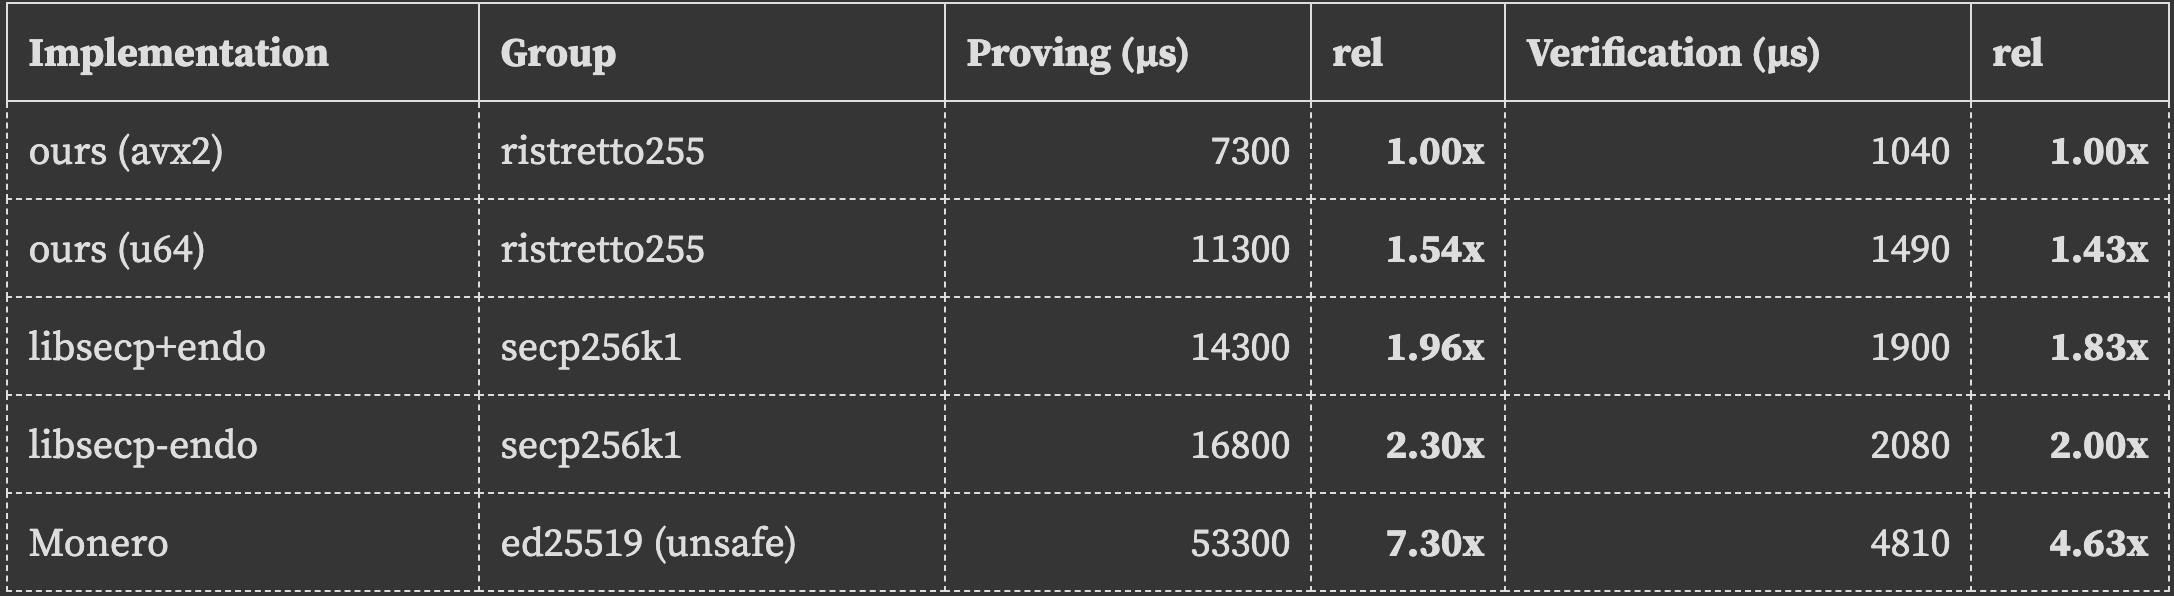

### Background
#### What is a [Bulletproof](https://crypto.stanford.edu/bulletproofs/)?

"Bulletproofs are short **non-interactive** zero-knowledge proofs that require **no trusted setup**."
- "non-interactive"?
    - No back-and-forth communication has to happen between the prover and the verifier (this also holds for zk-SNARKS, and others)
- "no trusted setup"?
    - no need for a trusted third party to generate initial parameters!
    - this is different from zk-SNARKs!

Innovation: if you wish to verify some constraint on a vector of m elements, a prove can actually do so by sending only log(m) commitments to be verified in a single proof.

Helps reduce blockchain bloat!

Tradeoff: verifying bulletproofs are more time-consuming than SNARKs.

#### Typical Application: Show that an encrypted text adheres to some set of constraints
Example: range proof
- **prove that an encrypted number is in a given range**
- without revealing anything else about the number

### "The Application Part of things" -- Code
#### Preliminary Definitions

- Let $p$ and $q$ be large prime numbers. (specifically should be a Sophie-Germain Prime for Pedersen Commitment)
    - **Sophie-Germain Prime**: $p$ and $2p + 1$ are prime! 
- Let $\mathbb{G}$ and $\mathbb{Q}$ denote cyclic groups of prime order $p$ and $q$, respectively
- Let $\mathbb{Z_p}$ and $\mathbb{Z_q}$ denote the ring of integers *modulo* $p$ and *modulo* $q$, respectively.
- Let **generators** of $\mathbb{G}$ be denoted by $g,h,v,u \in \mathbb{G}$, i.e. there exists a number $g\in \mathbb{G}$ such that $G = \{1, g, g^2,g^3,..., g^{p-1}\} \equiv \mathbb{Z_p}$. Note that not every element of $\mathbb{Z_p}$ is a generator of $\mathbb{G}$.

### Our Cryptographic Primitive: Pedersen Commitments

A **commitment scheme** in a Zero-knowledge Proof is a cryptographic primitive that allows a prover $\mathbb{P}$ to commit to only a single chosen value/statement from a finite set without the ability to change it later (**binding property**), while keeping it hidden from a verifier $\mathbb{V}$ (**hiding property**). 

The basis of our confidential transactions here is the **Pedersen Commitment**.

#### Classification of Binding Properties

Both binding and hiding properties are then further classified in increasing levels of security to be computational, statistical or perfect:

- **Computational** means that no **efficient** algorithm running in a practical amount of time can reveal the commitment amount or produce fake commitments, except with a **small probability**.
- **Statistical** means that the probability of an adversary doing the same in a finite amount of time is negligible.
- **Perfect** means that a quantum adversary (an attacker with infinite computing power) cannot tell what amount has been committed to, and is unable to produce fake commitments.

**KEY IDEA: No commitment scheme can simultaneously be perfectly binding and perfectly hiding.**

- Let $h^r\mathbf{g^x} = h^r \Pi_i g_i^{x_i} \in G$ be the **Pedersen Commitment** with $\mathbf{g} = (g_1, ..., g_n) \in \mathbb{G}^n$ and $\mathbf{x} = (x_1, ..., x_n) \in \mathbb{G}^n$

#### Pedersen Commitment

The Pedersen Commitment is a system for making a blinded, non-interactive commitment to a value.

Pedersen commitment scheme has the following properties:
- **Hiding**: A dishonest party cannot discover the honest party's value.
- **Binding**: A dishonest party cannot open his or her commitment in more than one way
- **Non-correlation**: A dishonest party cannot commit to a value that is in some significant way correlated to the honest party's value.

In [183]:
function create_generator(prime_number::BigInt)
    g_basis_of_cyclic_group::BigInt=7919
    # have to ensure that these are both prime AND Safe Primes
    @assert isprime(prime_number) 
    @assert isprime((2*prime_number) + 1)
    return g_basis_of_cyclic_group^big(rand(0:prime_number-1))
end;

In [184]:
p = big(1511) # 1511 or 131 or 11
q = 2*p + 1
@show isprime(p);
@show isprime(q)
g = create_generator(p)
h = create_generator(q)
r0 = big(rand(1:p-1))
r1 = big(rand(1:p-1))
x0 = big(rand(0:p-1))
x1 = big(rand(0:p-1));

isprime(p) = true
isprime(q) = true


In [185]:
function pedersen_commit(h::BigInt, g::BigInt, x::BigInt, r::BigInt)
    return (h^r)*(g^x)
end;

### Homomorphic Commitments
It's important to note that regular Pedersen Commits are also homomorphic, such that for messages $x_0$ and $x_1$, and blinding factors $r_0$ and $r_1$, we have 

$$C(x_0,r_0) \cdot C(x_1,r_1) = C(x_0 + x_1, r_0 + r_1)$$

In [186]:
@time C0 = pedersen_commit(h,g,x0,r0)
@time C1 = pedersen_commit(h,g,x1,r1);
@time C_both = pedersen_commit(h,g,x0 + x1,r0 + r1);

  0.089916 seconds (2.17 k allocations: 29.730 MiB)
  0.141004 seconds (487 allocations: 33.454 MiB, 3.68% gc time)
  0.282555 seconds (636 allocations: 60.863 MiB, 1.23% gc time)


In [187]:
@show C0 * C1 == C_both;

C0 * C1 == C_both = true


In [188]:
@show length(string(C0))
@show length(string(C1))
@show length(string(C_both));

length(string(C0)) = 4108326
length(string(C1)) = 5074276
length(string(C_both)) = 9182601


### Elliptic Curve Pedersen Commitment 
#### Or "How I learned stop worrying and love the libraries"

KEY QUOTE
```
Given a secure elliptic curve (e.g. secp256k1), a Pedersen commitment can be implemented using the same interface as usual but instead of prime field modular exponentiation, EC point multiplication and addition are used. The use of EC Pedersen commitments is almost exactly the same as the general prime field implementation:
```

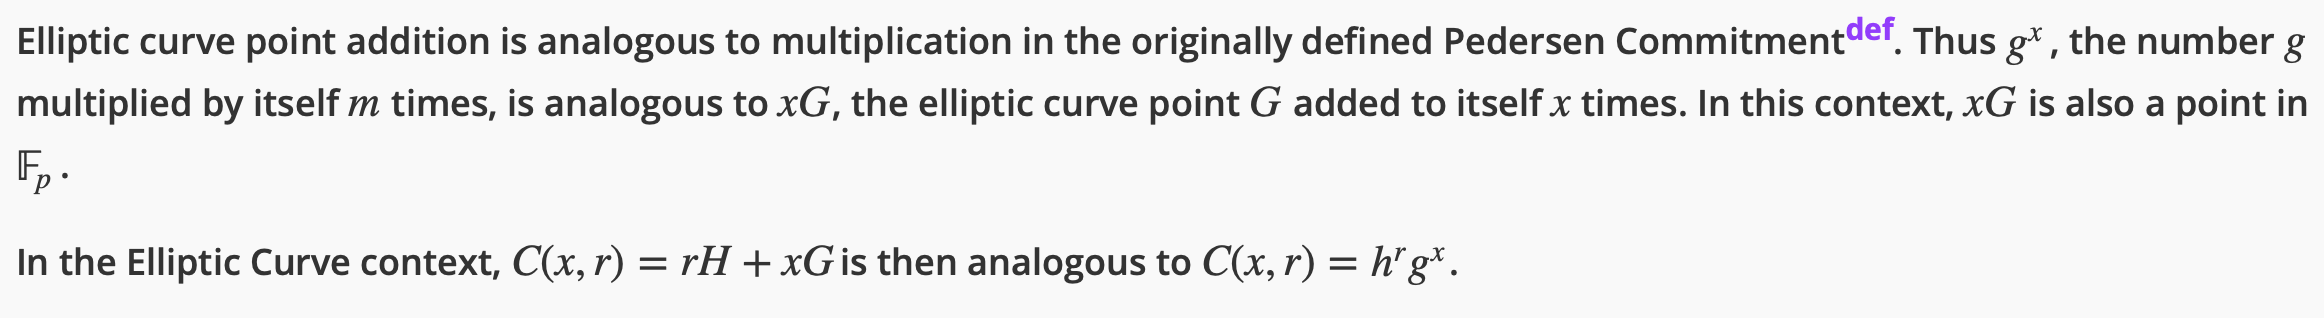

In [189]:
using ECC;
using SHA;

In [222]:
# scep256k1 generator point
G_ec = S256Point(big"0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798",
              big"0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8")
# THIS IS NOT CORRECT, just haven't figured it out yet
#G_ec = big"0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798"
# H is a "Nothing up my Sleeve" number -- the SHA 256 hash of the generator point G
H_nums = parse(BigInt, bytes2hex(sha256(string(G_ec))),base=16);

In [223]:
function ec_pedersen_commit(x::BigInt, r::BigInt)
    #return x*G_ec + r*H_nums
    return x*G_ec + r*G_ec
end;

In [224]:
P0 = ec_pedersen_commit(x0,r0)
P1 = ec_pedersen_commit(x1,r1)
P_both = ec_pedersen_commit(x0 + x1, r0 + r1);

#### ALSO Additively Homomorphic (in different ways)
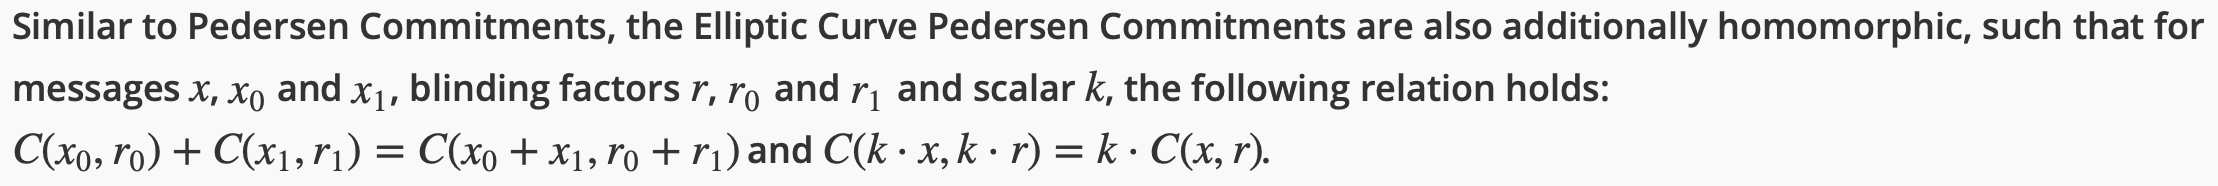

In [225]:
P0 + P1 == P_both

true

In [226]:
scalar = BigInt(rand(1:p-1))
scalar*ec_pedersen_commit(x0,r0) == ec_pedersen_commit(x0*scalar,r0*scalar)

true

In [227]:
@show length(string(P0))
@show length(string(P1))
@show length(string(P_both));

length(string(P0)) = 152
length(string(P1)) = 152
length(string(P_both)) = 152


# ALL BELOW HERE IS INCOMPLETE

### Vector Pedersen Commitment

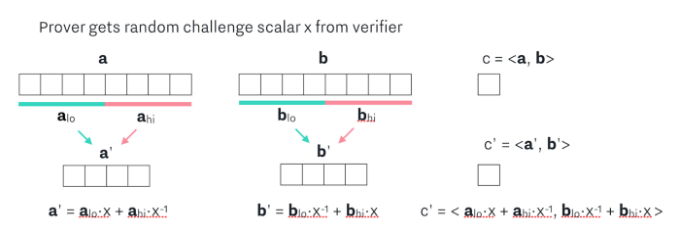

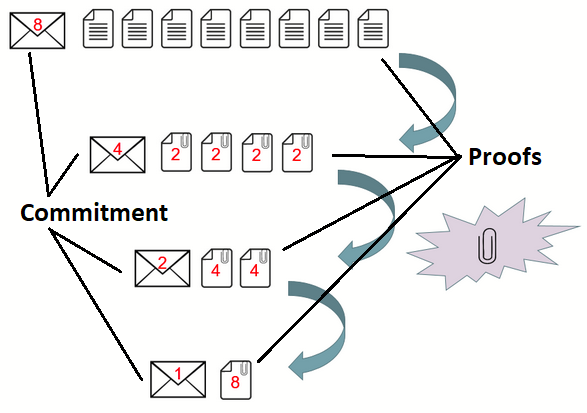

In [232]:
function ec_vector_pedersen_commit(a,b)
    @assert length(a) == length(b)
    N = length(a)
    sum = G_ec
    for index in 1:N
        if sum == G_ec
            sum = ec_pedersen_commit(a[index],b[index])
        else
            sum = sum + ec_pedersen_commit(a[index],b[index])
        end
    end;
    return sum
end;

In [237]:
LENGTH = 8
a = zeros(BigInt, 8)
b = zeros(BigInt, 8)
for i in 1:LENGTH
   a[i] = BigInt(rand(1:p-1))
   b[i] = BigInt(rand(1:p-1))
end
P1 = ec_vector_pedersen_commit(a,b)

scep256k1 Point(𝑥,𝑦):
39266c2848f58af447e5ce4f61cb3ba69c3bfdad7e5742fbba4ca3f4f175a291,
7be4b8729d1e2fa80fee16e5bfcdf4ef2cff2872e9c7fea2c1997d6c5d7f1efe

In [238]:
P2 = ec_pedersen_commit(dot(a,b),BigInt(0))

scep256k1 Point(𝑥,𝑦):
a787d0241e67e30516e7fbc9b39e2984bcf1b748450891a193717b2867fcca5f,
b9d50b19b30d950af4b72b36d3d763b9e835274eb99e3a148aa6e122f69c30c1

### Security of Bulletproofs: 


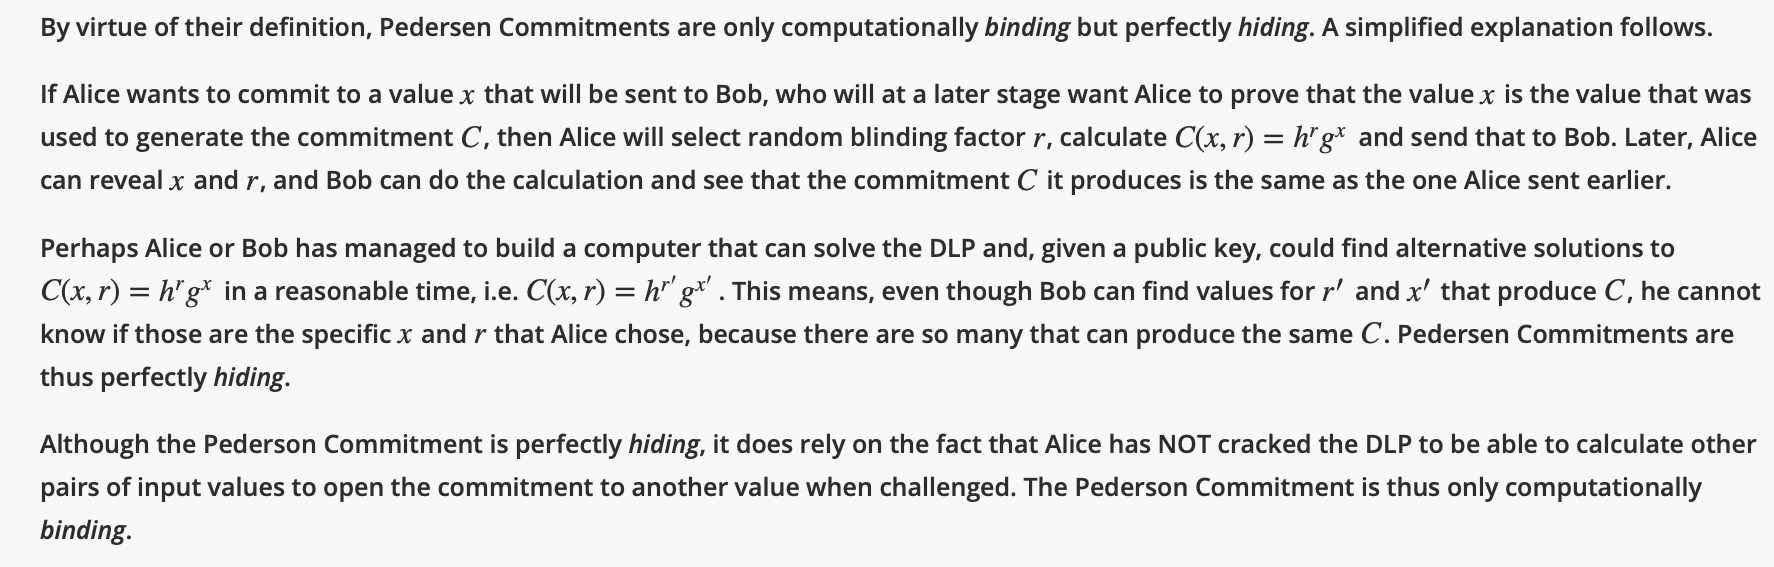

### Inner Product Protocol: "Why a proof on the inner product?"

It's a straightforward, isolated task. 

We'll have a prover $P$ that provides "committed" versions of 2 vectors to a verifier $V$ to convince the verifier that P knows 2 vectors $a,b$ such that:

**Naive Solution: Just send the committed vectors directly!**

#### Relation: Naive Attempt
$$(g,h\in\mathbb{G}^n, u,P \in \mathbb{G}; a,b \in \mathbb{Z}^n_p)\,\,\,\,\,\, P = g^a h^b \cdot u^{\langle a,b \rangle}$$



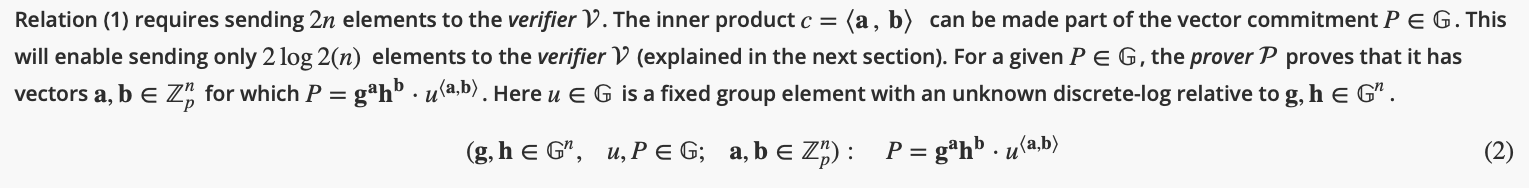

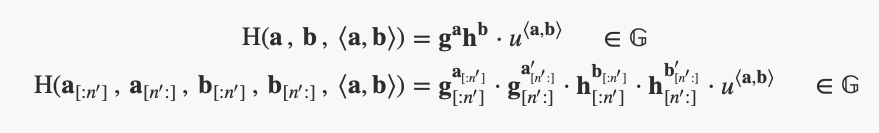

Walking through the steps of the reduction

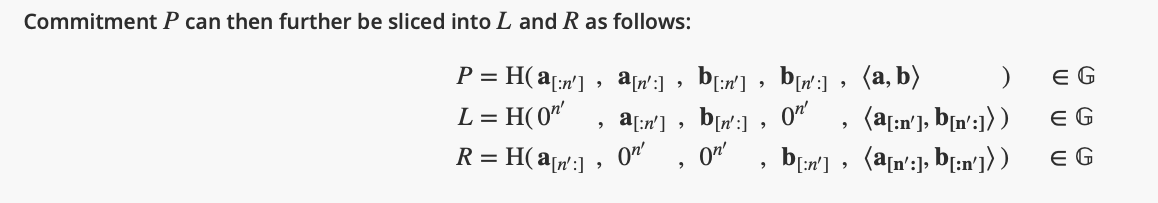

In [163]:
function H(a1,a2,b1,b2,dot_prod,g,h,u)
    N = length(g)
    g1 = g[1:N÷2]
    g2 = g[(N÷2 + 1):end]
    h1 = h[1:N÷2]
    h2 = h[(N÷2 + 1):end]
    return dot(dot(g1.^a1, g2.^a2), dot(h1.^b1,h2.^b2))*(u^dot_prod)
end;

In [201]:
P = dot(g.^a, h.^b)*u^(dot(a,b));

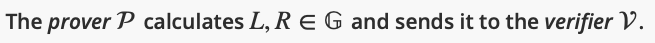

In [202]:
function get_LR(a,b,g,h,u)
    N = length(g)
    L = dot(g[(N÷2 + 1):end].^a[1:N÷2], h[1:N÷2].^b[(N÷2 + 1):end])*u^(dot(a[1:N÷2],b[(N÷2 + 1):end]))
    R = dot(g[1:N÷2].^a[(N÷2 + 1):end], h[(N÷2 + 1):end].^b[1:N÷2])*u^(dot(a[(N÷2 + 1):end],b[1:N÷2]))
    #L = H(0, a[1:N÷2], b[(N÷2 + 1):end], 0, dot(a[(N÷2 + 1):end], b[1:N÷2]), g, h, u)
    #R = H(a[(N÷2 + 1):end], 0, 0, b[1:N÷2], dot(a[1:N÷2], b[(N÷2 + 1):end]), g, h, u)
    return L, R
end;

In [203]:
L, R = get_LR(a,b,g,h,u);

In [204]:
@show length(string(L))
@show length(string(R))
@show length(string(P))
L*R == P

length(string(L)) = 3759
length(string(R)) = 6741
length(string(P)) = 24348


false

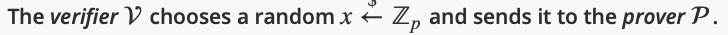

In [167]:
@show x = rand(1:p-1)
@show x_inv = invmod(x,p)
@show (x_inv*x) % p;

x = rand(1:p - 1) = 2
x_inv = invmod(x, p) = 2
(x_inv * x) % p = 1


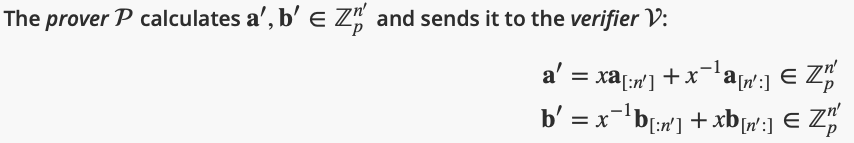

In [168]:
# todo: determine if we need to do this mod p
a_prime = broadcast(%,x*a[1:N÷2] + x_inv*(a[(N÷2 + 1):end]),p)
b_prime = broadcast(%,x_inv*b[1:N÷2] + x*(b[(N÷2 + 1):end]),p);

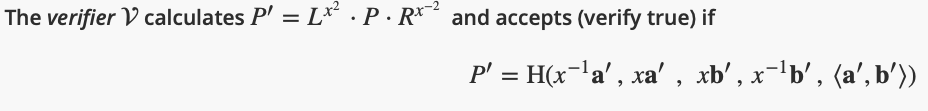

In [179]:
P_prime = H(x_inv*a_prime, x*a_prime, x*b_prime, x_inv*b_prime, dot(a_prime,b_prime), g, h, u);
P_prime == (L^(x^2 % p)) * P * (R^(invmod(x^2,p)))

false

In [180]:
P_prime

246616462974543461933764

In [181]:
(L^(x^2)) * P * (R^(invmod(x^2,p)))

13506186401665732144255976199846513231195716208956938141121764129246688932852016502799209009915192044384787256838094376086130117513078649460341963769622699070338082061435020048741895051837724677189159773798400000

### Conclusions 
#### Lessons Learned
- "Say the line, Bart!" -> "Don't roll your own crypto..." 
- In all seriousness, the existing libraries of dalek-cryptography will probably be more-than enough for any future applications I want to do
- The Julia community does not have superb support for cryptographic primitives (YET)
- Notation on Bulletproofs can be extremely frustrating.
    - 80% of my effort on this involved trying to concretize and verify some symbol that was used
        - 50% of that was spent finding where sources differed in describing Bulletproofs
        - 30% of that was 
        - 20% of it was dumb mistakes :) 
    - I imagine that with a few more years' time, we'll have better explorations out there

#### Given more time, what would you do?
- I'd probably try and extend the ECC.jl (Julia package for Ellipical Curve Crypto) functionality a bit, so as to more appropriately use its primitives for commitments
- Try just using the existing Rust library, THEN implementing the underlying primitives
    - Benchmark anything I create with that of the rust library to see performance differences w/ Julia's optimizations for vector math (I imagine things would be a lot slower).


# RUN ME
run all cells below here before beginning execution elsewhere

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

In [ ]:
versioninfo()

In [132]:
using Pkg;
Pkg.add("Latexify");
Pkg.add("Primes")
Pkg.add("LinearAlgebra");
Pkg.add("LinearOperators");
Pkg.add(url="https://github.com/roshii/ECC.jl")
using Latexify, Primes, LinearAlgebra, LinearOperators, Random, ECC;
Random.seed!(10); # ensure repeatable results... 

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...


No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
   Updating git-repo `https://github.com/roshii/ECC.jl`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [133]:
VERSION

v"1.5.1"